# 주가지수만들기
--------------
<STEP 1>
   1. TCI 지수 선정 : 일일 확진자(과거데이터 가중치{EMA,MA등 사용}, 거리두기 단계(1~4단계), Additional Wieghted_Value : 누적사망자/누적확진자)
   > (누적사망자/누적확진자) 가 클수록 코로나의 위험도가 증가한다고 판단하여 가중치 값으로 선정
   2. TCI 지수와 코스피, 코스닥 움직임 상관관계 예측
---------------
<STEP 2>
   1. TCI 지수 산출을 위한 데이터 만들기 ('2020.03.10' ~ '2022.02.28')
   > 지수 산출방법 : ```(추가로더적을 부분)``` 4번까지 한다음에 다시 피드백해서 정하기
   2. 코스피, 코스닥 동기간 종가 불러오기
   3. 임의로 만든 TCI와 KOSPI & KOSDAQ 상관관계 비교
   4. 산업군별로 데이터분석
      > 상관성 높은 산업군에서 예측모델 사용권장
      ``예측은 아마도 헬스케어는 + , 운송업은 -``

In [19]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
from datetime import datetime
from scipy import interpolate

import warnings
warnings.filterwarnings('ignore')

In [20]:
# Assign Corona.csv to df
df = pd.read_csv('./datasets/Corona.csv')
dist = pd.read_excel('./datasets/Dist.xlsx')
Unemp = pd.read_excel('./datasets/실업자.xlsx')
csi = pd.read_excel('./datasets/CSI.xlsx')
esi = pd.read_excel('./datasets/ESI.xlsx')

# Preprocessing Corona Data

In [21]:
# Preprocessing Corona Data
df.columns = ["1", 'Date', 'DeadCnt', 'ConfirmedCnt', "2", "3", "4", "5", "6", "7"]
dist.columns = ['Date', 'Level']
df.drop([str(i) for i in range(1,8)],axis=1,inplace=True) # Drop Unecessary Columns
df = df.sort_values('Date') # Sorting DATE
df['DailyDeadCnt'] = (df['DeadCnt']-df['DeadCnt'].shift(1)).fillna(0) # Create DailyDeadCnt by using difference & fill NAN by 0
df['DailyConfirmedCnt'] = (df['ConfirmedCnt']-df['ConfirmedCnt'].shift(1)).fillna(0) # Create DailyConfirmedCnt by using difference & fill NAN by 0
df['D/C(%)'] = (df['DeadCnt']/df['ConfirmedCnt'])*100 # Create D/C
df.drop(['DeadCnt','ConfirmedCnt'],axis=1,inplace=True) # Drop Unecessary Columns
df.reset_index(drop=True, inplace=True) # Reset index
df['Date'] = df['Date'].str[0:4] + "-" + df['Date'].str[5:7] + "-" +df['Date'].str[8:10] # Change Date style YYYY-MM-DD
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True) # Change datatype from object to datetime

# Add Corona Level
df = pd.merge(df, dist, left_on='Date', right_on='Date', how = 'left') # Merge df & Corona Level
df.fillna(3, inplace=True) # ALL NAN index in Level column fill 3

# Add Number of Unemployed
Unemp['Date'] = pd.to_datetime(Unemp['Date']) # Change datatype from object to datetime
df = pd.merge(df, Unemp, left_on='Date', right_on='Date', how='left') # Merge Unemp & df
df['Num'] = df['Num'].interpolate(method='values') # Interpolate Num

# Add CSI, ESI
csi['Date'] = pd.to_datetime(csi['Date']) # Change datatype from object to datetime
df = pd.merge(df, csi, left_on='Date', right_on='Date', how='left') # Merge csi & df
esi['Date'] = pd.to_datetime(esi['Date']) # Change datatype from object to datetime
df = pd.merge(df, esi, left_on='Date', right_on='Date', how='left') # Merge esi & df
df.iloc[:,6:13] = df.iloc[:,6:13].interpolate(method='values') # Interpolate Num

# Preprocessing stock index

In [22]:
# Read_csv
Kospi = pd.read_csv('./datasets/Kospi.csv')
Kodaq = pd.read_csv(('./datasets/Kodaq.csv'))
Bio = pd.read_csv(('./datasets/Bio.csv'))
Hc = pd.read_csv(('./datasets/Hc.csv'))
Trans = pd.read_csv(('./datasets/Trans.csv'))
Multi_Index = pd.read_csv('./datasets/makeup_travel_flight_index.csv')

In [23]:
# Change Columns Name
Bio.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'TA']
Hc.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'TA']
Trans.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'TA']
Multi_Index.columns = ['Date', 'MakeUp', 'Trav', 'Flight']

In [24]:
Target_list_df = [Kospi, Kodaq, Bio, Hc, Trans, Multi_Index]
for i, col in enumerate(Target_list_df):
    col['Date'] = pd.to_datetime(col['Date'],infer_datetime_format=True)
    col.set_index('Date', inplace=True)

In [25]:
# Preprocessing
df_c = df
sp_str = ['Kospi', 'Kosdq', 'Bio', 'Hc', 'Trans']
sp_df = [Kospi, Kodaq, Bio, Hc, Trans]

for i, col in enumerate(sp_df): # Merge Kospi & Kodaq into df_c
    corona_df = pd.merge(df_c, col['Close'], left_on='Date', right_on=col.index, how='inner')
    corona_df.rename(columns={'Close': sp_str[i]}, inplace=True)
    df_c = corona_df

corona_df.bfill(inplace=True)

corona_df = pd.merge(corona_df, Multi_Index, left_on='Date', right_on=Multi_Index.index, how='left')

In [26]:
Feature = corona_df.iloc[:,0:13]
Target = corona_df.drop(corona_df.columns[1:13], axis=1)

# EWM

In [27]:
df_reversed = Feature.sort_index(ascending=False)
df_reversed = df_reversed.assign(DCC_ewm=df_reversed['DailyConfirmedCnt'].ewm(span=5).mean())
Feature = Feature.assign(DCC_ewm=df_reversed['DCC_ewm'])
cd_p = Feature

# LogScale

In [28]:
cd_p['DCC_ewm'] = np.log1p(cd_p['DCC_ewm'])
cd_p['DailyConfirmedCnt'] = np.log1p(cd_p['DailyConfirmedCnt'])

In [29]:
# cd_p['DCC_ewm'] = cd_p['DCC_ewm'] * cd_p['Level']
# cd_p.drop('Level', axis=1)

# Train & Test

In [30]:
from sklearn.model_selection import train_test_split
import reg_model
import score_model
from imp import reload
reload(reg_model)
reload(score_model)

corona_feature1 = cd_p[cd_p.columns[1:].drop('DailyConfirmedCnt')]
corona_feature2 = cd_p[cd_p.columns[1:].drop(['DailyConfirmedCnt','Num'])]
corona_target = Target['Flight'] # Select target

sample = []
for i in range(2):
    globals()[f'X_train{i+1}, X_test{i+1}, y_train{i+1}, y_test{i+1}'] = train_test_split(globals()[f'corona_feature{i+1}'], corona_target, test_size=0.3, random_state=0)
    sample.append(globals()[f'X_train{i+1}, X_test{i+1}, y_train{i+1}, y_test{i+1}'])

In [31]:
rg = reg_model.RegALL()
sm = score_model.ScoreALL()

* Multiple Regression Pred & Score For Single Index

In [32]:
# Create Regression pred & score 
pred_list_df = []
score_list_df = []
FI_list_df = []
pred_list = []
score_list = []
FI_list_name = ['RFR', 'XGBR']
reg_list = ['linreg', 'Logreg', 'Las', 'Rid', 'Elastic', 'RFR', 'XGBR']
rgm = [rg.Linreg, rg.Logreg, rg.Las, rg.Rid, rg.Elastic, rg.RFR, rg.XGBR]
for j in range(2):
    for i,name in enumerate(reg_list): # Chose Number of Sample
        globals()[f'pred_{reg_list[i]}'], globals()[f'score_{reg_list[i]}'] = rgm[i](sample[j][0], sample[j][1], sample[j][2], pred=True, score=True)

        pred_list.append(globals()[f'pred_{reg_list[i]}'])
        score_list.append(globals()[f'score_{reg_list[i]}'])

    fit_RFR = rg.RFR(sample[j][0], sample[j][1], sample[j][2], feature_importances_=True)
    fit_XGBR = rg.XGBR(sample[j][0], sample[j][1], sample[j][2], feature_importances_=True)
    FI_list_df.append([fit_RFR, fit_XGBR])
        
    pred_list_df.append(pred_list)
    score_list_df.append(score_list)
    pred_list = []
    score_list = [] 

In [33]:
# Listing for scoring
pred_list_name = ['pred_linreg', 'pred_Logreg', 'pred_Las', 'pred_Rid', 'pred_Elastic', 'pred_RFR', 'pred_XGBR']

# r2_score, explained_variance_score  
for j in range(2): # Chose Number of Sample   
    for i in range(len(pred_list_name)):
        print(f"\n <{pred_list_name[i]} #{j+1}>")
        sm.r2_(sample[j][3],pred_list_df[j][i])
        sm.evs_(sample[j][3],pred_list_df[j][i])
        print(f'{pred_list_name[i]} score : {score_list_df[j][i]}')


 <pred_linreg #1>
r2_score : 0.9330
explained_variance_score : 0.9351
pred_linreg score : 0.9493

 <pred_Logreg #1>
r2_score : 0.9512
explained_variance_score : 0.9512
pred_Logreg score : 0.1265

 <pred_Las #1>
r2_score : 0.9255
explained_variance_score : 0.9275
pred_Las score : 0.9438

 <pred_Rid #1>
r2_score : 0.9329
explained_variance_score : 0.9350
pred_Rid score : 0.9493

 <pred_Elastic #1>
r2_score : 0.9229
explained_variance_score : 0.9248
pred_Elastic score : 0.941

 <pred_RFR #1>
r2_score : 0.9891
explained_variance_score : 0.9891
pred_RFR score : 0.9983

 <pred_XGBR #1>
r2_score : 0.9904
explained_variance_score : 0.9906
pred_XGBR score : 1.0

 <pred_linreg #2>
r2_score : 0.9338
explained_variance_score : 0.9357
pred_linreg score : 0.9493

 <pred_Logreg #2>
r2_score : 0.9668
explained_variance_score : 0.9670
pred_Logreg score : 0.1559

 <pred_Las #2>
r2_score : 0.9228
explained_variance_score : 0.9252
pred_Las score : 0.9448

 <pred_Rid #2>
r2_score : 0.9336
explained_varian

* feature_importances_

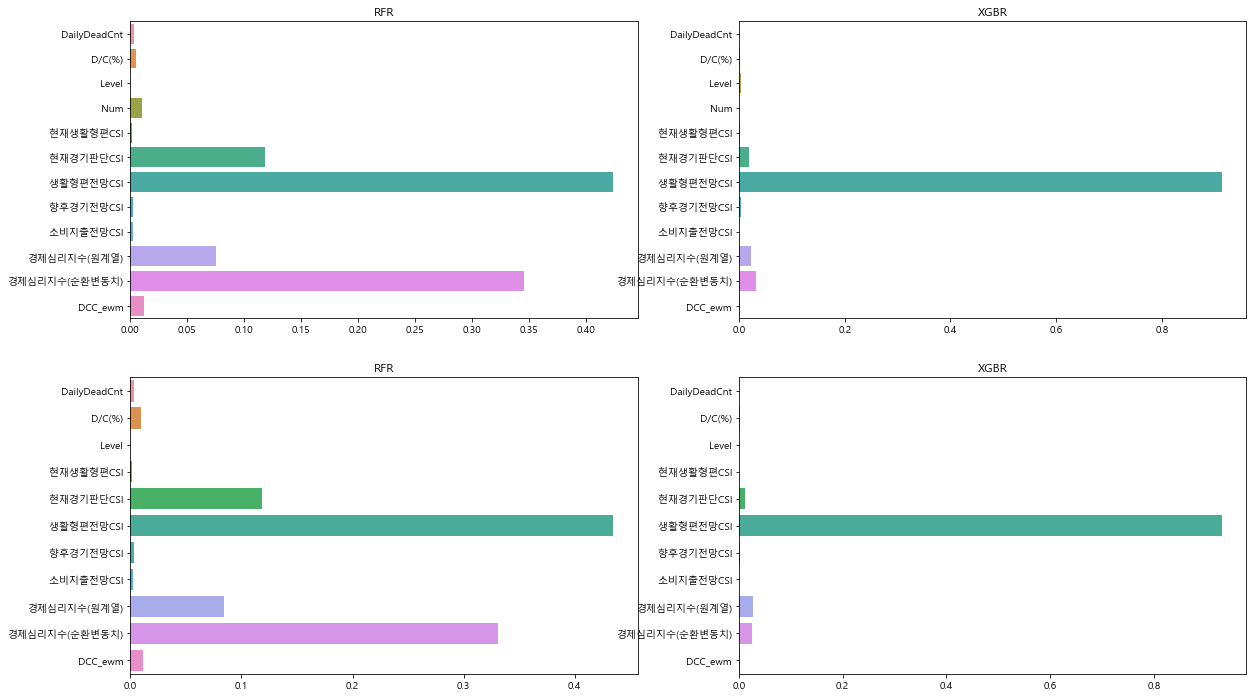

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

fig, axes = plt.subplots(nrows=len(FI_list_df), ncols=len(FI_list_df[0]),figsize=(20,12), facecolor='w')

for i in range(len(FI_list_df)):
    for j in range(len(FI_list_df[0])):
        importances_values = FI_list_df[i][j].feature_importances_
        importances = pd.Series(importances_values, index = sample[i][0].columns)
        
        sns.barplot(x=importances_values, y=importances.index, ax=axes[i][j]).set_title(FI_list_name[j])

# plt.savefig('./compare.png')


In [35]:
Target.columns[1:]

Index(['Kospi', 'Kosdq', 'Bio', 'Hc', 'Trans', 'MakeUp', 'Trav', 'Flight'], dtype='object')

* Single Regression Pred & Score For Multiple Index

In [37]:
corona_feature = cd_p[cd_p.columns[1:].drop('DailyConfirmedCnt')]
sample = []
corona_target = Target.iloc[:,1:]
for i in range(len(corona_target.columns)):
    X_train, X_test, y_train, y_test = train_test_split(corona_feature, corona_target.iloc[:,i], test_size=0.3, random_state=0)
    sample.append([X_train, X_test, y_train, y_test])

# Create Regression pred & score
pred_list_df = []
score_list_df = []
FI_list_df = []
for i in range(len(corona_target.columns)): # Chose Number of Sample
    pred_linreg, score_linreg = rg.Linreg(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)
    # pred_Logreg, score_Logreg = rg.Logreg(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)
    # pred_Las, score_Las = rg.Las(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)
    # pred_Rid, score_Rid = rg.Rid(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)
    # pred_Elastic, score_Elastic = rg.Elastic(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)
    # pred_RFR, score_RFR = rg.RFR(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)
    # pred_XGBR, score_XGBR = rg.XGBR(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)

    pred_list_df.append(pred_linreg)
    score_list_df.append(score_linreg)

    # pred_list_df.append([pred_linreg, pred_Logreg, pred_Las, pred_Rid, pred_Elastic, pred_RFR, pred_XGBR])
    # score_list_df.append([score_linreg, score_Logreg, score_Las, score_Rid, score_Elastic, score_RFR, score_XGBR])

    fit_RFR = rg.RFR(sample[i][0], sample[i][1], sample[i][2], feature_importances_=True)
    fit_XGBR = rg.XGBR(sample[i][0], sample[i][1], sample[i][2], feature_importances_=True)

    FI_list_df.append([fit_RFR, fit_XGBR])

# Listing for scoring
pred_list_name = ['pred_linreg']
# pred_list_name = ['pred_linreg', 'pred_Logreg', 'pred_Las', 'pred_Rid', 'pred_Elastic', 'pred_RFR', 'pred_XGBR']

# r2_score, explained_variance_score  
for j in range(len(corona_target.columns)): # Chose Number of Sample   
    for i in range(len(pred_list_name)):
        print(f" <{corona_target.columns[j]}>")
        sm.r2_(sample[j][3],pred_list_df[j])
        # sm.evs_(sample[j][3],pred_list_df[j])
        print(f'{pred_list_name[i]} score : {score_list_df[j]}')

 <Kospi>
r2_score : 0.9610
pred_linreg score : 0.9549
 <Kosdq>
r2_score : 0.9096
pred_linreg score : 0.9024
 <Bio>
r2_score : 0.6798
pred_linreg score : 0.5816
 <Hc>
r2_score : 0.6552
pred_linreg score : 0.583
 <Trans>
r2_score : 0.9177
pred_linreg score : 0.9113
 <MakeUp>
r2_score : 0.8687
pred_linreg score : 0.8477
 <Trav>
r2_score : 0.8344
pred_linreg score : 0.8486
 <Flight>
r2_score : 0.9330
pred_linreg score : 0.9493
